In [1]:
# fundamentals
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.metrics import confusion_matrix

#  printing of number without scientific notation
np.set_printoptions(precision=3,suppress=True)

# metric
from sklearn.metrics import mean_squared_error as MSE

In [110]:
# load data of sensor community
df = pd.read_csv("../data/df_backup.csv", index_col=0) # cleaned training data

# convert timestamp to datetime
df.timestamp = pd.to_datetime(df.timestamp)
df

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,humidity_sensors,...,precip,pressure_dwd,pressure_sealevel,temperature_dwd,wind_direction,wind_speed,PM10_median,PM10_threshold,PM2p5_median,PM2p5_threshold
0,2,2020-01-01 00:00:00,Frankfurt,50.042000,8.436000,212.110833,24.278724,140.574167,16.827501,96.000000,...,0.0,1023.1,1036.5,0.0,40.0,2.7,433.292292,1299.876875,241.772228,725.316683
1,2,2020-01-01 01:00:00,Frankfurt,50.042000,8.436000,196.873043,24.933247,129.469130,16.857172,96.100000,...,0.0,1022.9,1036.3,0.1,20.0,2.8,286.935200,860.805600,151.105000,453.315000
2,2,2020-01-01 02:00:00,Frankfurt,50.042000,8.436000,188.258182,36.770146,124.460455,26.337616,96.633333,...,0.0,1022.8,1036.2,-1.1,70.0,2.2,182.878125,548.634375,91.174182,273.522545
3,2,2020-01-01 03:00:00,Frankfurt,50.042000,8.436000,166.444500,30.844667,105.790000,21.422815,97.600000,...,0.0,1022.3,1035.7,-0.4,80.0,1.6,145.721667,437.165000,79.951200,239.853600
4,2,2020-01-01 04:00:00,Frankfurt,50.042000,8.436000,101.033600,18.991551,62.073600,12.735376,97.550000,...,0.0,1022.1,1035.4,0.2,50.0,2.0,100.915342,302.746025,52.900587,158.701761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193003,86,2021-12-31 19:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1011.2,1023.9,10.6,180.0,2.6,11.838750,35.516250,7.394400,22.183200
3193004,86,2021-12-31 20:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1011.9,1024.6,10.9,200.0,3.5,11.160000,33.480000,7.139600,21.418800
3193005,86,2021-12-31 21:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1012.2,1024.9,11.2,200.0,3.3,11.075000,33.225000,6.772500,20.317500
3193006,86,2021-12-31 22:00:00,Frankfurt,50.134582,8.527964,NaN,NaN,NaN,NaN,NaN,...,0.0,1012.3,1025.0,11.6,210.0,3.0,10.849583,32.548750,7.827200,23.481600


In [109]:
# load data of sensor community
#df = pd.read_csv("../data/processed_sensor_dwd.csv", index_col=0)

# convert timestamp to datetime
df.timestamp = pd.to_datetime(df.timestamp)

# add sensor IDs
df_location = df.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon']]
df_location['location_id'] = df_location.index+1
df = df.merge(df_location, on=['lat', 'lon'], how='left')

# define lists with columns
non_data_cols = ['location_id', 'timestamp', 'lat', 'lon','city']
data_cols = sorted([col for col in list(df.columns) if col not in non_data_cols])
data_cols_wo_std = [col for col in data_cols if 'std' not in col]
std_cols = [col for col in data_cols if 'std' in col]

# reorganize columns: first non-data columns, then sorted data columns
df = df.reindex(columns=non_data_cols+data_cols)
df

,location_id,timestamp,lat,lon,city,PM10,PM10_median,PM10_std,PM10_threshold,PM2p5,...,precip,pressure_dwd,pressure_sealevel,pressure_sensors,pressure_std,temperature_dwd,temperature_sensors,temperature_std,wind_direction,wind_speed
0,NaN,2020-01-01 00:00:00,50.042000,8.436000,Frankfurt,212.110833,433.292292,24.278724,1299.876875,140.574167,...,0.0,1023.1,1036.5,NaN,NaN,0.0,2.700000,NaN,40.0,2.7
1,NaN,2020-01-01 01:00:00,50.042000,8.436000,Frankfurt,196.873043,286.935200,24.933247,860.805600,129.469130,...,0.0,1022.9,1036.3,NaN,NaN,0.1,2.400000,NaN,20.0,2.8
2,NaN,2020-01-01 02:00:00,50.042000,8.436000,Frankfurt,188.258182,182.878125,36.770146,548.634375,124.460455,...,0.0,1022.8,1036.2,NaN,NaN,-1.1,2.133333,0.057735,70.0,2.2
3,NaN,2020-01-01 03:00:00,50.042000,8.436000,Frankfurt,166.444500,145.721667,30.844667,437.165000,105.790000,...,0.0,1022.3,1035.7,NaN,NaN,-0.4,1.850000,0.057735,80.0,1.6
4,NaN,2020-01-01 04:00:00,50.042000,8.436000,Frankfurt,101.033600,100.915342,18.991551,302.746025,62.073600,...,0.0,1022.1,1035.4,NaN,NaN,0.2,1.650000,0.212132,50.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193003,NaN,2021-12-31 19:00:00,50.134582,8.527964,Frankfurt,NaN,11.838750,NaN,35.516250,NaN,...,0.0,1011.2,1023.9,NaN,NaN,10.6,NaN,NaN,180.0,2.6
3193004,NaN,2021-12-31 20:00:00,50.134582,8.527964,Frankfurt,NaN,11.160000,NaN,33.480000,NaN,...,0.0,1011.9,1024.6,NaN,NaN,10.9,NaN,NaN,200.0,3.5
3193005,NaN,2021-12-31 21:00:00,50.134582,8.527964,Frankfurt,NaN,11.075000,NaN,33.225000,NaN,...,0.0,1012.2,1024.9,NaN,NaN,11.2,NaN,NaN,200.0,3.3
3193006,NaN,2021-12-31 22:00:00,50.134582,8.527964,Frankfurt,NaN,10.849583,NaN,32.548750,NaN,...,0.0,1012.3,1025.0,NaN,NaN,11.6,NaN,NaN,210.0,3.0


In [114]:
df_base = df.drop(['WRTR', 'humidity_dwd', 'humidity_sensors','humidity_std', 'precip', 'pressure_dwd', 'pressure_sealevel',
       'pressure_sensors', 'pressure_std', 'temperature_dwd', 'temperature_sensors', 'temperature_std', 'wind_direction',
       'wind_speed', 'PM10_median', 'PM10_threshold', 'PM2p5_median',
       'PM2p5_threshold'], axis=1).sort_values(['location_id', 'timestamp'])
df_base

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std
1807032,1,2020-01-01 00:00:00,Frankfurt,50.032,8.784,NaN,NaN,NaN,NaN
1807033,1,2020-01-01 01:00:00,Frankfurt,50.032,8.784,NaN,NaN,NaN,NaN
1807034,1,2020-01-01 02:00:00,Frankfurt,50.032,8.784,NaN,NaN,NaN,NaN
1807035,1,2020-01-01 03:00:00,Frankfurt,50.032,8.784,NaN,NaN,NaN,NaN
1807036,1,2020-01-01 04:00:00,Frankfurt,50.032,8.784,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1649131,182,2021-12-31 19:00:00,Bremen,53.140,8.904,16.034583,2.242751,11.147500,1.040452
1649132,182,2021-12-31 20:00:00,Bremen,53.140,8.904,21.777500,5.855478,13.389167,5.004302
1649133,182,2021-12-31 21:00:00,Bremen,53.140,8.904,19.258333,2.085969,9.638750,0.533881
1649134,182,2021-12-31 22:00:00,Bremen,53.140,8.904,21.307083,3.152129,10.092500,1.884177


In [85]:
# another methode to calculate simple base line model
#df_base_1a = df_base.query("location_id==1")
#df_base_1a['PM10_1day_2'] = df_base_1a.apply(lambda x: df_base_1a[(df_base_1a['timestamp'] == (x['timestamp'] - pd.Timedelta(hours=1)))]['PM10'].mean(), axis=1) # mean, because a function is needed and mean of on values give the value
#df_base_1a
#df_threshold[col+'_median'] = df_threshold.apply(lambda x: df_cur[(df_cur['timestamp'] == x['timestamp'])][col].median(), axis=1)

In [115]:
# calculate predicted values for PM10 as mean of previous three days -> predict tomorrow (1day)
df_base['PM10_1day'] = (df_base.groupby(['location_id'])['PM10'].shift(24) + df_base.groupby(['location_id'])['PM10'].shift(48) + df_base.groupby(['location_id'])['PM10'].shift(72)) / 3

# give predicted values for PM10 as PM of previous day
df_base['PM10_1day_simple'] = df_base.groupby(['location_id'])['PM10'].shift(24)

# calculate predicted values for PM10 as mean of previous three day's measurements/predictions --> predict the day after tomorrow (2days), ...
df_base['PM10_2days'] = (df_base.groupby(['location_id'])['PM10_1day'].shift(24) + df_base.groupby(['location_id'])['PM10'].shift(48) + df_base.groupby(['location_id'])['PM10'].shift(72)) / 3
df_base['PM10_3days'] = (df_base.groupby(['location_id'])['PM10_2days'].shift(24) + df_base.groupby(['location_id'])['PM10_1day'].shift(48) + df_base.groupby(['location_id'])['PM10'].shift(72)) / 3
df_base['PM10_4days'] = (df_base.groupby(['location_id'])['PM10_3days'].shift(24) + df_base.groupby(['location_id'])['PM10_2days'].shift(48) + df_base.groupby(['location_id'])['PM10_1day'].shift(72)) / 3

df_base.sample(10)
#df_base.tail(30)
#df_base.head(30)

,location_id,timestamp,city,lat,lon,PM10,PM10_std,PM2p5,PM2p5_std,PM10_1day,PM10_1day_simple,PM10_2days,PM10_3days,PM10_4days
2710394,18,2020-12-25 02:00:00,Frankfurt,50.082000,8.518000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1281234,147,2020-01-22 18:00:00,Bremen,53.072000,8.826000,13.133333,11.738094,6.426667,7.346231,24.562239,25.918800,22.519799,24.481444,15.696477
2678618,179,2021-05-12 02:00:00,Bremen,53.131823,8.732302,9.761200,1.442158,5.830400,0.604762,4.095261,3.105000,4.864836,6.092637,7.051593
1644105,182,2021-06-05 09:00:00,Bremen,53.140000,8.904000,20.673333,2.154039,16.884762,1.373461,8.670030,15.383478,5.423242,4.102095,7.770754
2324266,140,2020-12-18 10:00:00,Bremen,53.068000,8.818000,10.425417,2.104996,4.860000,0.453508,34.788978,19.232917,39.324517,26.616902,50.568398
2161001,31,2020-05-08 17:00:00,Frankfurt,50.102303,8.677232,6.248000,1.729703,3.164333,0.573914,6.845807,10.853214,5.225055,5.527950,5.595646
2034511,44,2021-12-07 07:00:00,Frankfurt,50.114000,8.662000,16.289167,11.829826,4.649167,4.547062,16.309730,24.044000,13.146129,14.455477,12.130933
538323,64,2021-05-15 03:00:00,Frankfurt,50.124000,8.712000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1271667,146,2020-12-20 03:00:00,Bremen,53.072000,8.820000,15.508000,2.070940,10.072000,0.450527,31.430606,36.965600,30.509059,33.384805,26.503702
3071227,134,2020-02-12 19:00:00,Bremen,53.060000,8.678000,15.744091,3.862905,2.630455,0.522316,10.465500,12.991429,11.585840,13.862508,27.519164


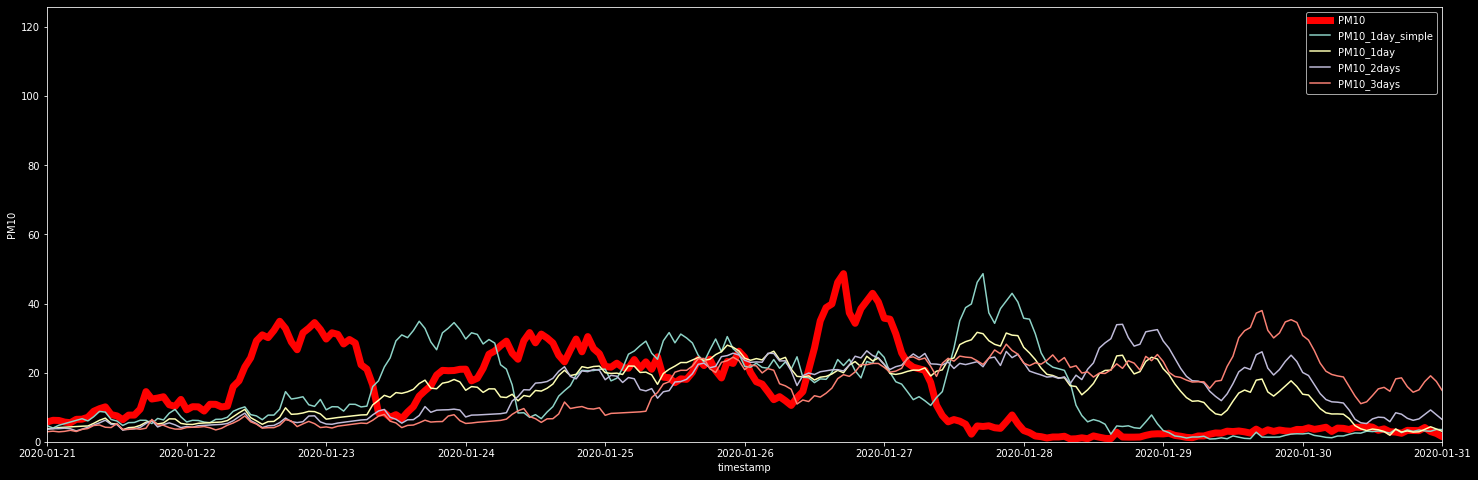

In [156]:
# plot example
location = 4

plt.figure(figsize=(25, 8))

sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10', color='red', linewidth=7)
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_1day_simple')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_1day')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_2days')
sns.lineplot(data=df_base.query(f'location_id=={location}'), x='timestamp', y='PM10_3days')
plt.plot([0, locations], [rmse_all['1day'], rmse_all['1day']], linewidth=2)
plt.legend(['PM10', 'PM10_1day_simple', 'PM10_1day', 'PM10_2days', 'PM10_3days'])
plt.xlim(pd.to_datetime('2020-01-21'),pd.to_datetime('2020-01-31'))
plt.ylim(0);

(0.0, 120.0)

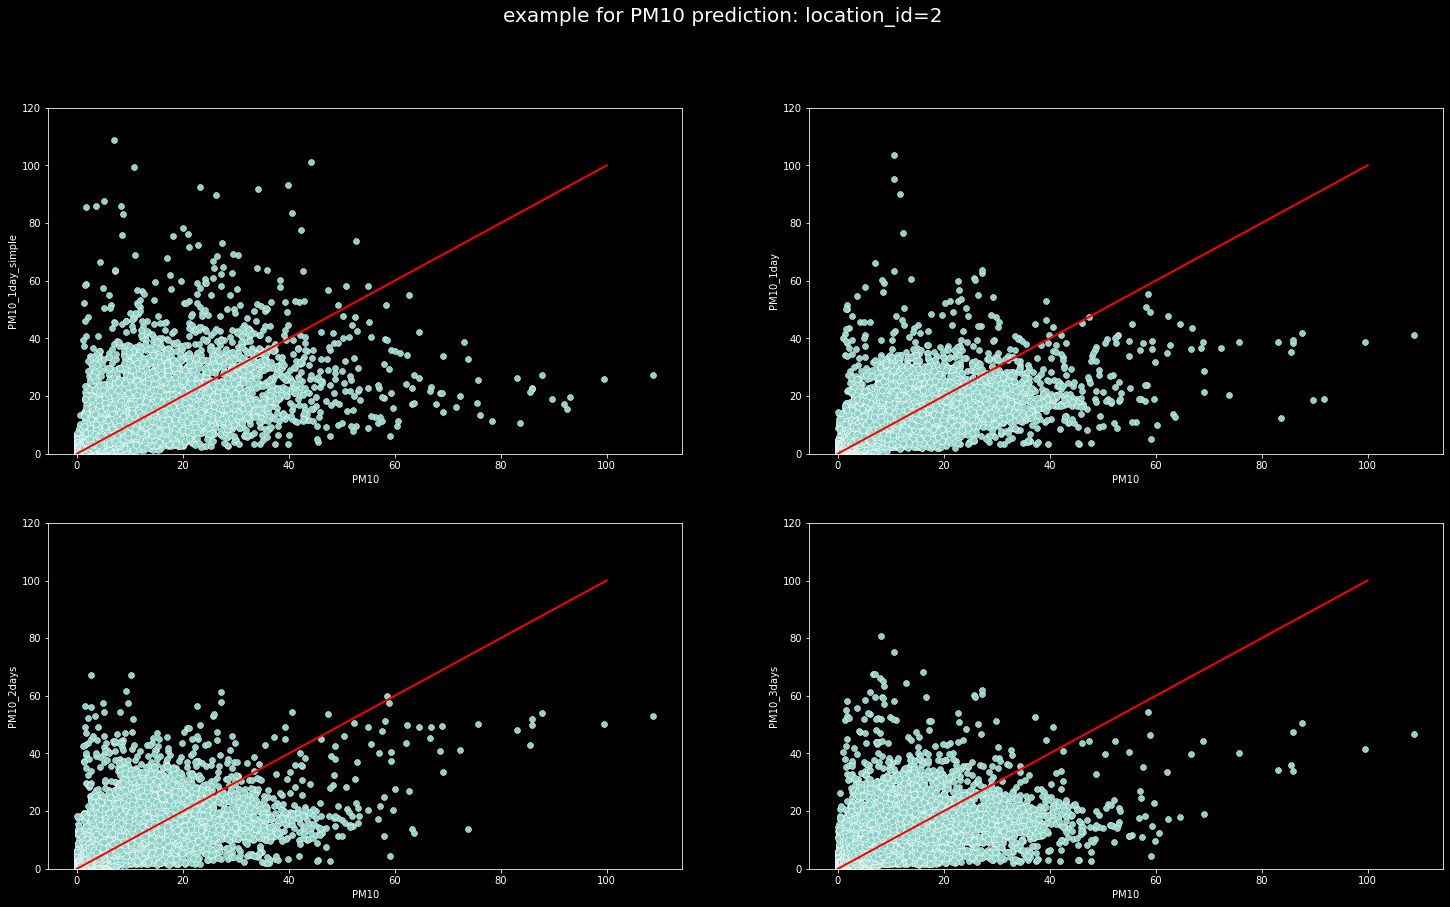

In [116]:
# plot example
location = 2
plt.figure(figsize=(25, 14))
plt.suptitle(f"example for PM10 prediction: location_id={location}", fontsize=20) # title of plot

plt.subplot(2,2,1)
#plt.title('example: location_id=2')
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_1day_simple')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,2)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_1day')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,3)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_2days')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

plt.subplot(2,2,4)
sns.scatterplot(data=df_base.query(f"location_id=={location}"), x='PM10', y='PM10_3days')
plt.plot([0, 100], [0, 100], linewidth=2, color='red')
plt.ylim(0,120)

for all locations the RMSE of 3days is: 14.53 µg/m3
for all locations the RMSE of 2days is: 13.79 µg/m3
for all locations the RMSE of 1day is: 12.62 µg/m3
for all locations the RMSE of 1day_simple is: 13.82 µg/m3


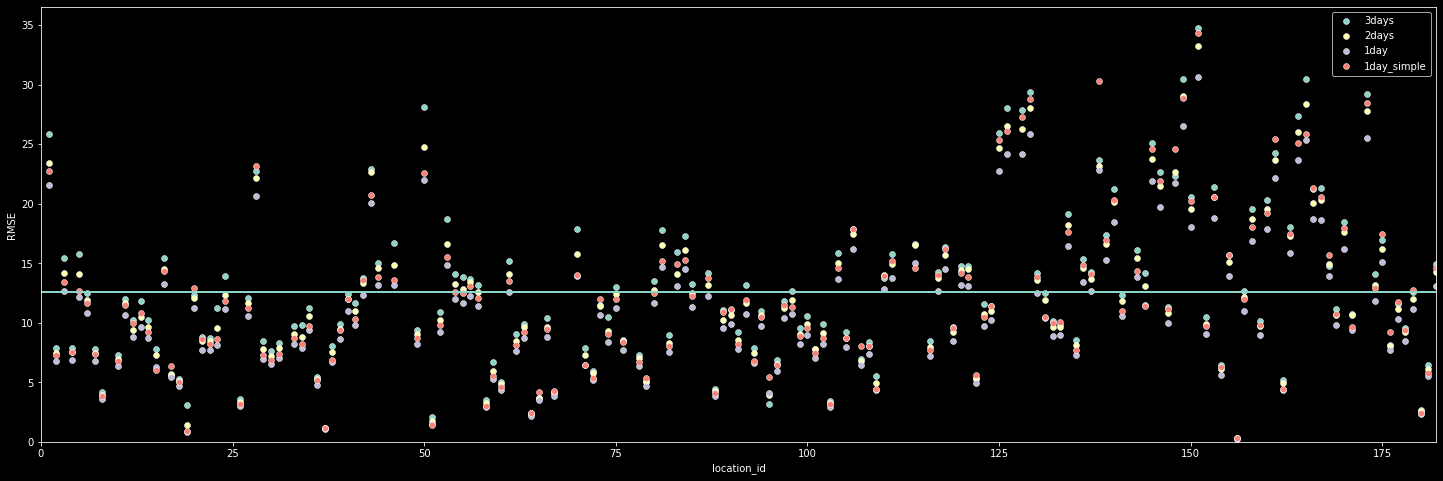

In [154]:
# calculate root mean squared error (RMSE) per location, over all sensors an per city
locations = df.location_id.nunique() # number of locations
df_RMSE = df_base.groupby(['location_id', 'city', 'lat', 'lon']).PM10.count().reset_index().drop('PM10', axis=1) # create DataFrame of right shape

#sensor = 2

def calc_rmse(PM, base_model):
    """calculates RMSE and add it to dataframe df_RMSE
    Args:
        PM (str): PM10 or PM2.5
        base_model (str): base line model
    Return: 
        rmse_all (float): RMSE for all locations, for Bremen and for Frankfurt
    """
    # RMSE for all sensors
    df_sensor = df_base.dropna(axis=0)
    rmse_all = np.sqrt(MSE(df_sensor[PM], df_sensor[f"{PM}_{base_model}"]))
    print(f"for all locations the RMSE of {base_model} is:", round(rmse_all,2), "µg/m3")

    # RMSE for Bremen
    df_Bremen = df_sensor[df_sensor['city'] == 'Bremen']
    rmse_Bremen = np.sqrt(MSE(df_Bremen[PM], df_Bremen[f"{PM}_{base_model}"]))

    # RMSE for Frankfurt
    df_Frankfurt = df_sensor[df_sensor['city'] == 'Frankfurt']
    rmse_Frankfurt = np.sqrt(MSE(df_Frankfurt[PM], df_Frankfurt[f"{PM}_{base_model}"]))

    # RMSE per location
    for i in range(1,locations+1):
        df_sensor = df_base[df_base['location_id']==i].dropna(axis=0)
        if df_sensor.shape[0] != 0:
    #        print(i)
            rmse = np.sqrt(MSE(df_sensor[f"{PM}"], df_sensor[f"{PM}_{base_model}"]))
            df_RMSE.loc[i-1,f"{PM}_{base_model}"] = rmse
    return rmse_all, rmse_Bremen, rmse_Frankfurt

#test = 'hello'
#df_RMSE.loc[1,f"{test}"] = 2

base_line_models = ['3days', '2days', '1day', '1day_simple']

plt.figure(figsize=(25, 8))

rmse_all = dict()
rmse_Bremen = dict()
rmse_Frankfurt = dict()
for model in base_line_models:
    rmse_all[model], rmse_Bremen[model], rmse_Frankfurt[model] = calc_rmse('PM10', model)
    #df_RMSE.plot(kind='scatter', x='location_id', y=f"PM10_{model}")
    sns.scatterplot(data=df_RMSE, x='location_id', y=f"PM10_{model}")
plt.plot([0, locations], [rmse_all['1day'], rmse_all['1day']], linewidth=2)
plt.legend(base_line_models)
plt.xlim(0,locations)
plt.ylabel('RMSE')
plt.ylim(0);



In [197]:
df_RMSE

,location_id,city,lat,lon,PM10_1day_simple,PM10_1day,PM10_2days,PM10_3days
0,1,Frankfurt,50.032000,8.784000,201.673732,206.108289,235.912583,257.755790
1,2,Frankfurt,50.042000,8.436000,8.304442,7.660662,8.389448,8.872811
2,3,Frankfurt,50.046000,8.852000,14.413804,13.530804,15.061206,16.156780
3,4,Frankfurt,50.050000,8.690000,8.791006,7.989849,8.692699,9.085096
4,5,Frankfurt,50.054000,8.790000,135.058248,168.368707,205.898991,241.295146
...,...,...,...,...,...,...,...,...
177,178,Bremen,53.126000,8.760000,9.296088,8.399117,9.127899,9.530477
178,179,Bremen,53.131823,8.732302,13.883719,12.386343,13.410272,14.001641
179,180,Bremen,53.132000,8.708000,2.514294,2.410228,2.681893,2.727681
180,181,Bremen,53.132000,8.732000,5.555895,5.259402,5.871341,6.136063
